# Extract variables at bottom of ocean: an example with Age

This notebook shows a simple example of plotting ocean Ideal Age. Ideal Age is a fictitious tracer which is set to zero in the surface grid-cell every timestep, and is aged by 1 year per year otherwise. It is a useful proxy for nutrients, such as carbon or oxygen (but not an exact analogue). 

One of the interesting aspects of age is that we can use it to show pathways of the densest water in the ocean by plotting a map of age in the lowest grid cell. This plot requires a couple of tricks to extract information from the lowest cell.

**Requirements:** COSIMA Cookbook, preferably installed via the `conda/analysis3` conda installation on NCI.

Compute times were calculated using the (48 cpus, 192 Gb mem) Jupyter Lab on NCI's Gadi with conda environment analysis3-24.04.

In [1]:
import intake
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import cartopy.crs as ccrs
import cmocean as cm

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
logging.getLogger('distributed.utils_perf').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 48
Total threads: 48,Total memory: 188.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41407,Workers: 48
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 188.55 GiB
Comm: tcp://127.0.0.1:40425,Total threads: 1
Dashboard: /proxy/38163/status,Memory: 3.93 GiB
Nanny: tcp://127.0.0.1:34005,


Add a database session. No database file has been specified so it will use the default database that indexes a number of COSIMA datasets

In [3]:
catalog = intake.cat.access_nri

Now, let's set the experiment and time interval, and average ideal age over a year.

In [6]:
experiment = '01deg_jra55v13_ryf9091'
variable = 'age_global'
start_time = '2099-01-01'
end_time   = '2099-12-31'

cat_subset = catalog[experiment]
var_search = cat_subset.search(variable=variable, frequency='1mon')
darray = var_search.to_dask()
age = darray[variable]
age = age.sel(time=slice(start_time, end_time))
age

<xarray.DataArray 'age_global' (time: 12, st_ocean: 75, yt_ocean: 2700,
                                xt_ocean: 3600)> Size: 35GB
dask.array<getitem, shape=(12, 75, 2700, 3600), dtype=float32, chunksize=(1, 7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 96B 2099-01-16 12:00:00 ... 2099-12-16 12:00:00
Attributes:
    long_name:      Age (global)
    units:          yr
    valid_range:    [0.e+00 1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_age_since_surface_contact

In [7]:
%%time
age_mean = age.mean(dim='time').compute()

CPU times: user 38.1 s, sys: 6.99 s, total: 45.1 s
Wall time: 46.6 s


The age variable is a 3D variable. There are a number of ways to extract the value at the bottom of the ocean. This notebook outlines two ways this can be achieved: *(i)* using masking and using *(ii)* indexing.

In this case masking is much slower than indexing, but for some use cases this has been the opposite. The masking approach has the benefit of not requiring the depth grid information.

## I. Masking approach

Create a mask of all the bottom cells. Can achieve this by taking the data, shift it up one cell in the vertical grid, find all non-NAN cells, and then negate this mask. Then mask the same data with with this mask, which will select out only the lowest level of non-NAN values in the data.

In a second step turn it into a boolean array for neatness.

In [9]:
bottom_mask = age_mean.where(~np.isfinite(age_mean.shift({'st_ocean': -1})))
bottom_mask = ~np.isnan(bottom_mask)
bottom_mask

<xarray.DataArray 'age_global' (st_ocean: 75, yt_ocean: 2700, xt_ocean: 3600)> Size: 729MB
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [10]:
%%time
bottom_age = age_mean.where(bottom_mask).sum(dim='st_ocean').compute()
bottom_age

CPU times: user 3.83 s, sys: 1.98 s, total: 5.81 s
Wall time: 3.91 s


<xarray.DataArray 'age_global' (yt_ocean: 2700, xt_ocean: 3600)> Size: 39MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

Load some things we need for plotting. Bathymetry for plotting the land mask, and lat/lon:

In [25]:
geolon_t

<xarray.DataArray 'geolon_t' (grid_y_T: 2700, grid_x_T: 3600)> Size: 78MB
[9720000 values with dtype=float64]
Dimensions without coordinates: grid_y_T, grid_x_T
Attributes:
    long_name:  Geographic longitude of T_cell centers
    units:      degrees_E

In [26]:
cat_subset = catalog[experiment]
var_search = cat_subset.search(variable='ht')
var_search = var_search.search(path=var_search.df['path'][0])
darray = var_search.to_dask()
bathymetry = darray['ht']

land = xr.where(np.isnan(bathymetry.rename('land')), 1, np.nan)

ds = xr.open_dataset("/g/data/ik11/grids/ocean_grid_01.nc")
ds = ds.rename(
    {
        "grid_x_C": "xu_ocean",
        "grid_y_C": "yu_ocean",
        "grid_x_T": "xt_ocean",
        "grid_y_T": "yt_ocean",
    }
)
geolon_t = ds.geolon_t
geolat_t = ds.geolat_t

bathymetry = bathymetry.drop_vars(["geolon_t", "geolat_t"])
bathymetry = bathymetry.assign_coords({"geolon_t": geolon_t, "geolat_t": geolat_t})

bottom_age = bottom_age.drop_vars(["geolon_t", "geolat_t"])
bottom_age = bottom_age.assign_coords({"geolon_t": geolon_t, "geolat_t": geolat_t})

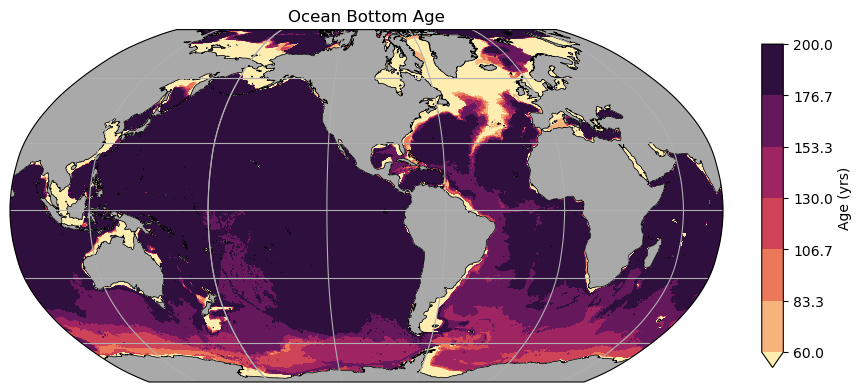

In [27]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))

# Add model land mask
land.plot.contourf(ax=ax,
                   colors='darkgrey',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Add model coastline
land.fillna(0).plot.contour(ax=ax,
                            colors='k',
                            levels=[0, 1],
                            transform=ccrs.PlateCarree(),
                            add_colorbar=False,
                            linewidths=0.5)

ax.gridlines(draw_labels=False)

bottom_age.plot.contourf(ax=ax,
                         x='geolon_t', y='geolat_t',
                         cmap=cm.cm.matter,
                         vmin=60,
                         vmax=200,
                         transform=ccrs.PlateCarree(),
                         cbar_kwargs={"label": "Age (yrs)", "fraction": 0.03, "aspect": 15, "shrink": 0.7})

plt.title('Ocean Bottom Age');

## II. Indexing approach

Here we grab the `kmt` variable out of `ocean_grid.nc`. Note that this is a static variable, so we just look for the last file (give `n=-1` as keyword argument to `getvar()` below). The `kmt` variable tells us the lowest cell which is active at each $(x, y)$ location.

In [28]:
cat_subset = catalog[experiment]
var_search = cat_subset.search(variable='kmt')
var_search = var_search.search(path=var_search.df['path'][0])
ds = var_search.to_dask()
kmt = ds['kmt']
kmt = kmt.fillna(1.0).astype(int) - 1
kmt.load()

<xarray.DataArray 'kmt' (yt_ocean: 2700, xt_ocean: 3600)> Size: 78MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolon_t  (yt_ocean, xt_ocean) float32 39MB nan nan nan nan ... nan nan nan
    geolat_t  (yt_ocean, xt_ocean) float32 39MB nan nan nan nan ... nan nan nan

Provided that `kmt` is loaded, `xarray` is smart enough to figure out what this line means, and extracts a 2-D field of bottom age for us.

In [29]:
%%time
bottom_age = age_mean.isel(st_ocean=kmt).compute()

CPU times: user 213 ms, sys: 88.9 ms, total: 302 ms
Wall time: 201 ms


And here is the plot:

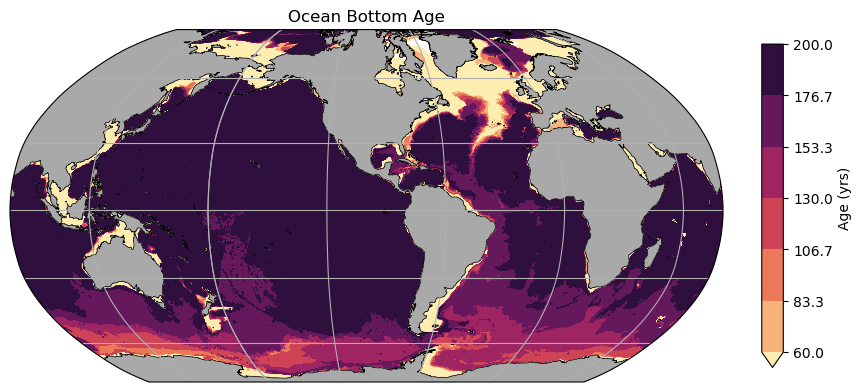

In [30]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))

# Add model land mask
land.plot.contourf(ax=ax,
                   colors='darkgrey',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Add model coastline
land.fillna(0).plot.contour(ax=ax,
                            colors='k',
                            levels=[0, 1],
                            transform=ccrs.PlateCarree(),
                            add_colorbar=False,
                            linewidths=0.5)

ax.gridlines(draw_labels=False)

bottom_age.plot.contourf(ax=ax,
                         x='geolon_t', y='geolat_t',
                         cmap=cm.cm.matter,
                         vmin=60,
                         vmax=200,
                         transform=ccrs.PlateCarree(),
                         cbar_kwargs={"label": "Age (yrs)", "fraction": 0.03, "aspect": 15, "shrink": 0.7})

plt.title('Ocean Bottom Age');

## Some remarks

A few things to note here:
* The continental shelves are all young - this is just because they are shallow.
* The North Atlantic is also relatively young, due to formation of NADW. Note that both the Deep Western Boundary Currents and the Mid-Atlantic Ridge both sustain southward transport of this young water.
* A signal following AABW pathways (northwards at the western boundaries) shows slightly younger water in these regions, but it has mixed somewhat with older water above.
* Even after 200 years, the water in the NE Pacific has not experienced any ventilation...

## Notes on performance

The indexing method requires the data to be loaded into memory and appears faster than it actually is if this isn't factored in. Calculations with large datasets that do not fit within memory will struggle in this case.

The indexing method does not perform well in a `dask` workflow where lazy loading is being used. 

The masking approach does not suffer from these limitations and when in doubt should be the preferred method. It also has the advantage of not requiring the grid data.

To illustrate this: a single month of bottom age from the original data using masking

In [35]:
%%time
age.isel(time=1).where(bottom_mask).sum(dim='st_ocean').compute()

CPU times: user 9.56 s, sys: 2.29 s, total: 11.9 s
Wall time: 13.4 s


<xarray.DataArray 'age_global' (yt_ocean: 2700, xt_ocean: 3600)> Size: 39MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    time      object 8B 2099-02-15 00:00:00

The same with indexing (different month to ensure no caching effects) is significantly slower

In [32]:
%%time
age.isel(time=3).isel(st_ocean=kmt).compute()

CPU times: user 1min 18s, sys: 3.82 s, total: 1min 22s
Wall time: 1min 25s


<xarray.DataArray 'age_global' (yt_ocean: 2700, xt_ocean: 3600)> Size: 39MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    st_ocean  (yt_ocean, xt_ocean) float64 78MB 0.5413 0.5413 ... 0.5413 0.5413
    time      object 8B 2099-04-16 00:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 39MB nan nan nan nan ... nan nan nan
    geolat_t  (yt_ocean, xt_ocean) float32 39MB nan nan nan nan ... nan nan nan
Attributes:
    long_name:      Age (global)
    units:          yr
    valid_range:    [0.e+00 1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_age_since_surface_contact

It is much faster to preload the data and then index it, but this does rely on their being sufficient memory

In [33]:
%%time
myage = age.isel(time=4).load()

CPU times: user 6.83 s, sys: 3.16 s, total: 9.99 s
Wall time: 9.64 s


In [34]:
%%time
myage.isel(st_ocean=kmt).compute()

CPU times: user 178 ms, sys: 104 ms, total: 282 ms
Wall time: 189 ms


<xarray.DataArray 'age_global' (yt_ocean: 2700, xt_ocean: 3600)> Size: 39MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    st_ocean  (yt_ocean, xt_ocean) float64 78MB 0.5413 0.5413 ... 0.5413 0.5413
    time      object 8B 2099-05-16 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 39MB nan nan nan nan ... nan nan nan
    geolat_t  (yt_ocean, xt_ocean) float32 39MB nan nan nan nan ... nan nan nan
Attributes:
    long_name:      Age (global)
    units:          yr
    valid_range:    [0.e+00 1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_age_since_surface_contact